# Data information

### Business background and goal

KKBOX offers subscription based music streaming service. When users signs up for our service, users can choose to either manual renew or auto-renew the service. Users can actively cancel their membership at any time.
The goal of this analysis is the prediction if a user will churn after subscription expires.

Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.

More about data: https://www.kaggle.com/c/kkbox-churn-prediction-challenge

**Why it's worth to predict if user will churn?**
<br><br>
Thanks to predicition if client will want to leave, company can tak relevant action to affect his decion eg. give a special offer, send information showing new benefits of the service etc.

Company can as well use churn predition analysis to asses which marketing actions or other special activities was the most effective and result in keeping clients.

### Data descritpion

**msno**: user id
<br>**is_churn**: This is what you will predict. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.
<br>
<br>**payment_method_id:** payment method
<br>**payment_plan_days:** length of membership plan in days
<br>**plan_list_price:**  amount to be paid as per plan in New Taiwan Dollar (NTD)
<br>**actual_amount_paid:**  actual amount paid in New Taiwan Dollar (NTD)
<br>**is_auto_renew:** yes(1)/no(0)
<br>**transaction_date:**  format %Y%m%d
<br>**membership_expire_date:**  format %Y%m%d
<br>**is_cancel:**  whether or not the user canceled the membership in this transaction.

<br>**date:** format %Y%m%d
<br>**num_25:** # of songs played less than 25% of the song length
<br>**num_50:** # of songs played between 25% to 50% of the song length
<br>**num_75:** # of songs played between 50% to 75% of of the song length
<br>**num_985:** # of songs played between 75% to 98.5% of the song length
<br>**num_100:** # of songs played over 98.5% of the song length
<br>**num_unq:** # of unique songs played
<br>**total_secs:** total seconds played

<br>**city**
<br>**bd:** age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
<br>**gender**
<br>**registered_via:** registration method
<br>**registration_init_time:** format %Y%m%d

# 1. Data loading

### 1.1 Imports

In [1]:
#Important libraries imports
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

#Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import lightgbm as lgb

from sklearn.model_selection import train_test_split

#Success metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score# <== our success metric
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer

#Functions for time-data
import time
from datetime import datetime

#Display columns in pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#Display all outputs of the cell not only last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 1.2 Data loading

In [2]:
df_members = pd.read_csv("members_v3.csv")
df_train = pd.read_csv("train_v2.csv")
df_transaction = pd.read_csv("transactions_v2.csv")
df_user_logs = pd.read_csv("user_logs_v2.csv")
df_test = pd.read_csv("sample_submission_v2.csv")

# 2. Exploration Data Analysis

### 2.1 Train dataset

In [3]:
df_train.head()
df_train.describe()

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


,is_churn
count,970960.000000
mean,0.089942
std,0.286099
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [4]:
df_train.msno.unique().shape, df_train.shape

((970960,), (970960, 2))

There is no duplicates in 'msno'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AA180C0E80>]],
      dtype=object)

0    883630
1     87330
Name: is_churn, dtype: int64

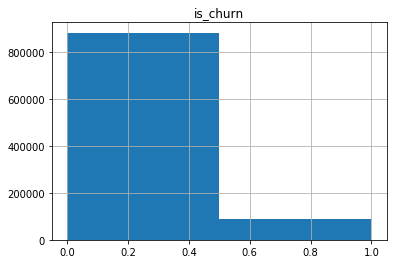

In [5]:
df_train.hist(bins =2)
df_train.is_churn.value_counts()

In [6]:
883630/(883630+87330)

0.9100580868418885

We can see that 91% of users in training dataset is going for renewal. It can lead to bit of bias, let's keep it in mind for further analys. 

### 2.2 Members dataset

Let's merge mebers dataset with train dataset.

In [7]:
train_members = pd.merge(left = df_train,right = df_members,how = 'inner',on=['msno'])
train_members.head()
train_members.info()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5,28,male,3,20131223
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13,20,male,3,20131223
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13,18,male,3,20131227
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1,0,NaN,7,20140109
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13,35,female,7,20140125


<class 'pandas.core.frame.DataFrame'>
Int64Index: 860967 entries, 0 to 860966
Data columns (total 7 columns):
msno                      860967 non-null object
is_churn                  860967 non-null int64
city                      860967 non-null int64
bd                        860967 non-null int64
gender                    388905 non-null object
registered_via            860967 non-null int64
registration_init_time    860967 non-null int64
dtypes: int64(5), object(2)
memory usage: 52.5+ MB


In [8]:
388905/860967

0.4517072082902132

In [9]:
train_members['gender']=train_members['gender'].fillna("NAN")
train_members.gender.value_counts()
train_members.info()

NAN       472062
male      204561
female    184344
Name: gender, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 860967 entries, 0 to 860966
Data columns (total 7 columns):
msno                      860967 non-null object
is_churn                  860967 non-null int64
city                      860967 non-null int64
bd                        860967 non-null int64
gender                    860967 non-null object
registered_via            860967 non-null int64
registration_init_time    860967 non-null int64
dtypes: int64(5), object(2)
memory usage: 52.5+ MB


55% of gender data are missing.
There is slightly more man than woman.

**Changing the format of dates to YYYY-MM-DD**

In [10]:
train_members['registration_init_time'] = train_members.registration_init_time.apply(
    lambda x: datetime.strptime(str(int(x)), "%Y%m%d").date() if pd.notnull(x) else "NAN")

##### 2.2.1 Members ['city']

Text(0,0.5,'Count')

Text(0.5,0,'City')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

Text(0.5,1,'Frequency of City Count in train_members Data Set')

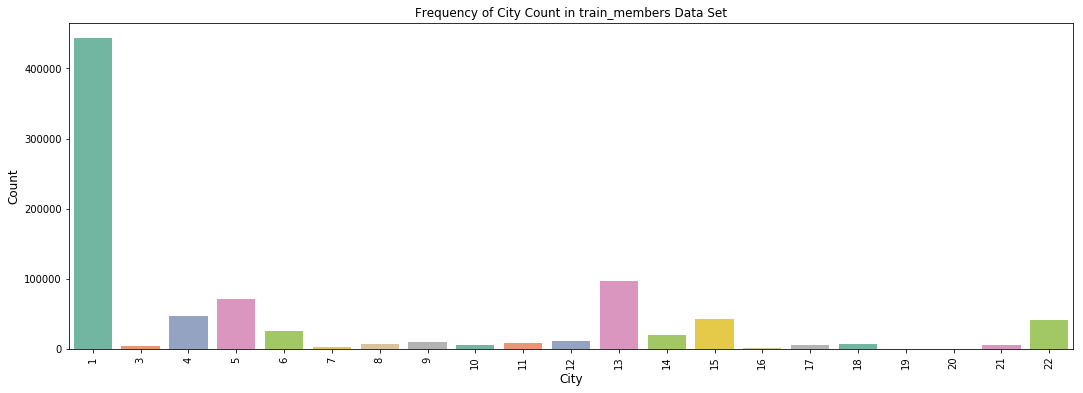

In [11]:
plt.figure(figsize=(18,6))
sns.countplot(x="city", data=train_members, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('City', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of City Count in train_members Data Set", fontsize=12)
plt.show()

We can clearly see that majority of users are from city 1. We can think on possible assumption that the city 1 is capital while rest of the cities are smaller ones.

**Churn distribution per city**

is_churn,0,1,0_%,1_%
city,,,,
21,4434,765,85.29,14.71
12,9798,1585,86.08,13.92
8,6568,1021,86.55,13.45
3,4385,672,86.71,13.29
10,5612,858,86.74,13.26
5,61373,9333,86.80,13.20
4,41133,6094,87.10,12.90
6,22708,3358,87.12,12.88
15,37649,5538,87.18,12.82


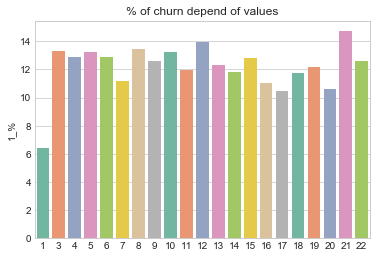

In [12]:
city_crosstab=pd.crosstab(train_members['city'],train_members['is_churn'])
city_crosstab["0_%"] =  round(city_crosstab[0]/(city_crosstab[1]+city_crosstab[0])*100, 2)
city_crosstab["1_%"] =  round(city_crosstab[1]/(city_crosstab[1]+city_crosstab[0])*100, 2)
city_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
ax = sns.barplot(x = city_crosstab.index.values, y = "1_%", data=city_crosstab, palette="Set2").set_title("% of churn depend of values")

In feature engineering we can consider creation of new column with split for 2 clusters: capital and other cities.

##### 2.2.2 Members ['bd'] - AGE

Text(0,0.5,'Count')

Text(0.5,0,'Age')

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

Text(0.5,1,'Frequency of City Count in train_members Data Set')

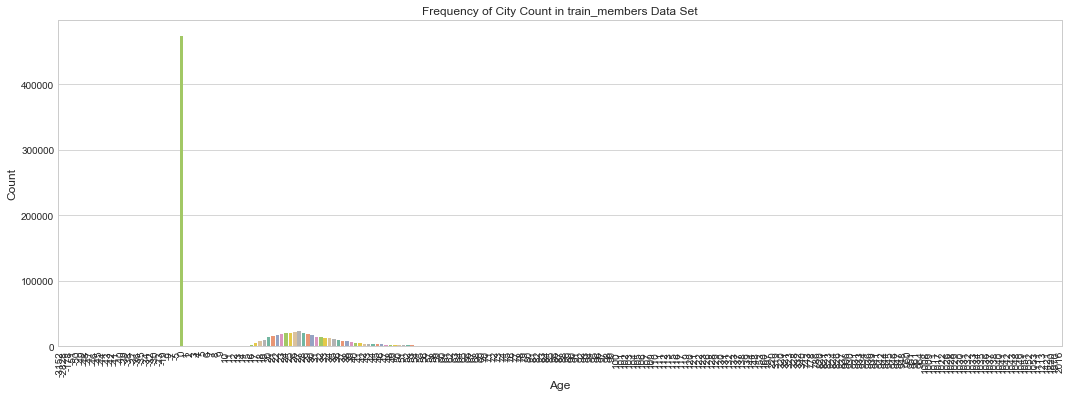

In [13]:
plt.figure(figsize=(18,6))
sns.countplot(x="bd", data=train_members, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of City Count in train_members Data Set", fontsize=12)
plt.show()

In [14]:
train_members.bd.value_counts()

 0       473729
 27       22786
 26       21829
 25       20651
 24       20296
 28       20244
 29       19533
 23       19238
 22       18035
 30       17175
 21       15633
 31       15123
 32       14406
 20       13678
 33       13229
 34       12154
 35       10959
 36        9985
 19        9861
 37        8858
 18        8207
 38        7679
 39        6651
 17        5913
 40        5663
 41        5221
 42        4305
 43        3723
 44        3266
 46        3015
 45        3010
 47        2889
 16        2544
 48        2539
 49        2320
 50        2027
 51        1970
 52        1748
 53        1445
 54        1159
 55        1021
 15         848
 56         844
 57         736
 58         541
 59         510
 60         455
 61         390
 62         309
 14         282
 63         258
 64         193
 65         171
 66         147
 67         140
 68          90
 106         81
 69          67
 117         65
 13          63
 70          57
 112         52
 72     

We can see that there are many of unreal data like negative age and very high age. We can see as well that a lot of members have 0 as age. Let's clear this to get better insights and more valuable data.

In [15]:
train_members['bd'] = train_members.bd.apply(lambda x: -1 if x<0 else x )
train_members['bd'] = train_members.bd.apply(lambda x: 101 if x>100 else x )

Text(0,0.5,'Age')

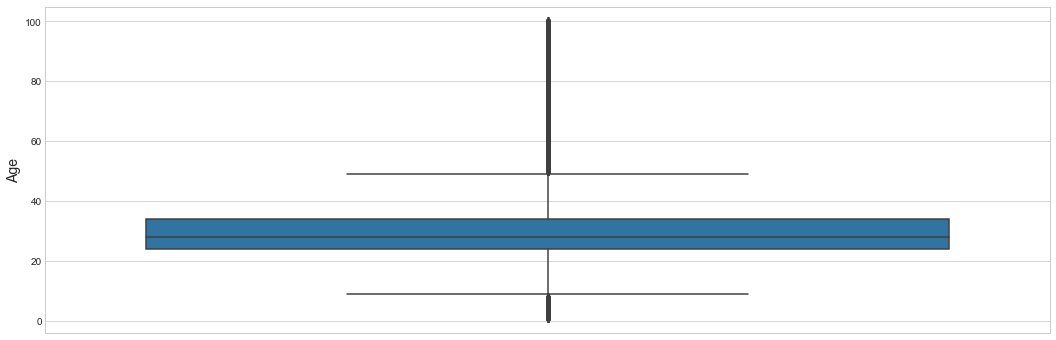

count    386715.000000
mean         29.904216
std           8.920391
min           1.000000
25%          24.000000
50%          28.000000
75%          34.000000
max         100.000000
Name: bd, dtype: float64

Text(0,0.5,'Count')

Text(0.5,0,'Age')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 <a list of 100 Text xticklabel objects>)

Text(0.5,1,'Frequency of City Count in train_members Data Set')

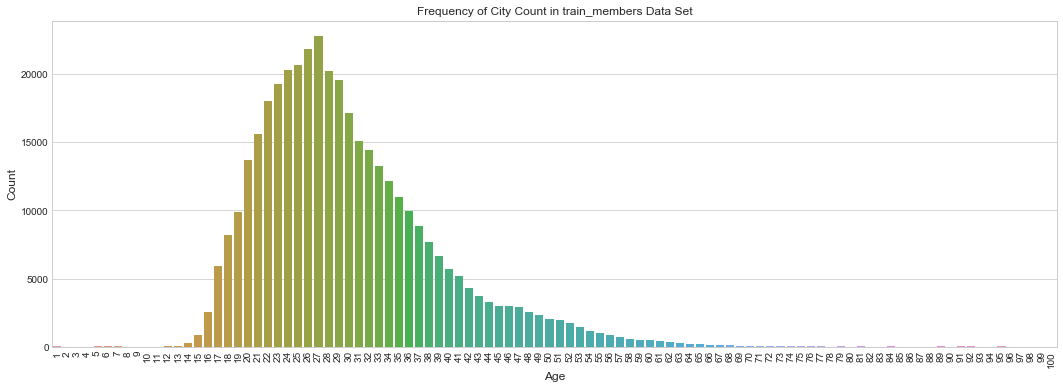

In [16]:
tmp_bd = train_members[(train_members.bd != 0) & (train_members.bd != -1) & (train_members.bd != 101)]
plt.figure(figsize=(18,6))
plt.rcParams['figure.figsize']=(20,10)
sns.boxplot(y="bd", data=tmp_bd);
plt.ylabel('Age', fontsize=14);
plt.show()

tmp_bd.bd.describe()

plt.figure(figsize=(18,6))
sns.countplot(x="bd", data=tmp_bd)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of City Count in train_members Data Set", fontsize=12)
plt.show()

After cleaning the data we see that majority of real data are from range of 24-34.
<br>Average age is ~29.

**Churn distribution per age**

is_churn,0,1,0_%,1_%
bd,,,,
99,1,1,50.00,50.00
14,166,116,58.87,41.13
13,41,22,65.08,34.92
15,581,267,68.51,31.49
4,7,3,70.00,30.00
16,1809,735,71.11,28.89
17,4330,1583,73.23,26.77
18,6076,2131,74.03,25.97
19,7535,2326,76.41,23.59


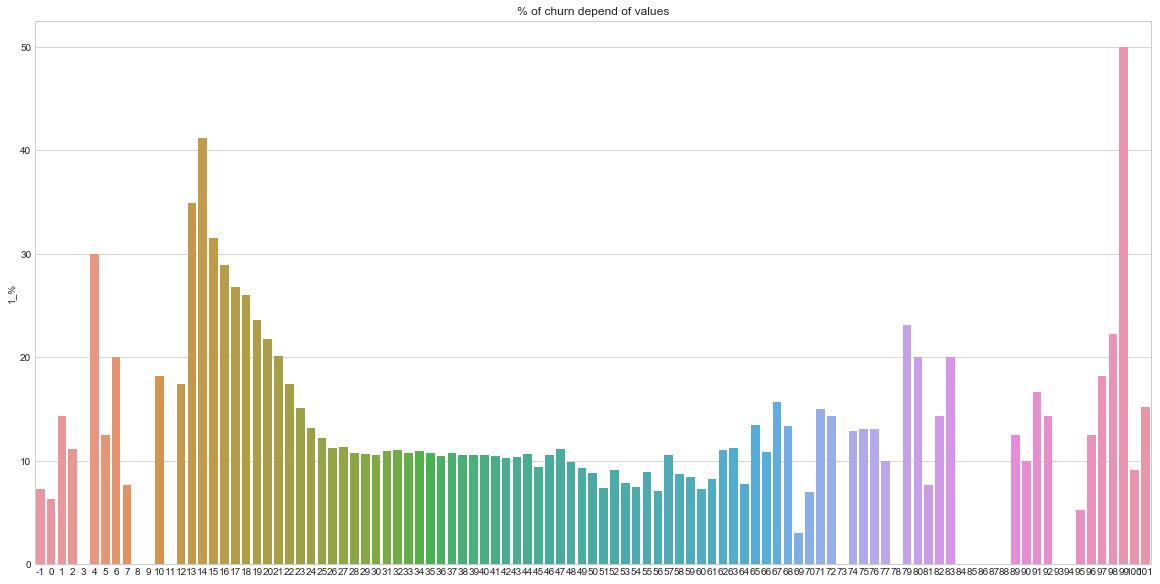

In [17]:
bd_crosstab=pd.crosstab(train_members['bd'],train_members['is_churn'])
bd_crosstab["0_%"] =  round(bd_crosstab[0]/(bd_crosstab[1]+bd_crosstab[0])*100, 2)
bd_crosstab["1_%"] =  round(bd_crosstab[1]/(bd_crosstab[1]+bd_crosstab[0])*100, 2)
bd_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = bd_crosstab.index.values, y = "1_%", data=bd_crosstab).set_title("% of churn depend of values")

We can clearly see that teens(13-19) tend to churn more often. I would split for category teen and others in FE(Feature engineering) and consider to separate in other category fake information outliers from tails.

##### 2.2.3 Members ['gender']

is_churn,0,1,0_%,1_%
gender,,,,
female,160404,23940,87.01,12.99
male,178165,26396,87.10,12.90
NAN,440950,31112,93.41,6.59


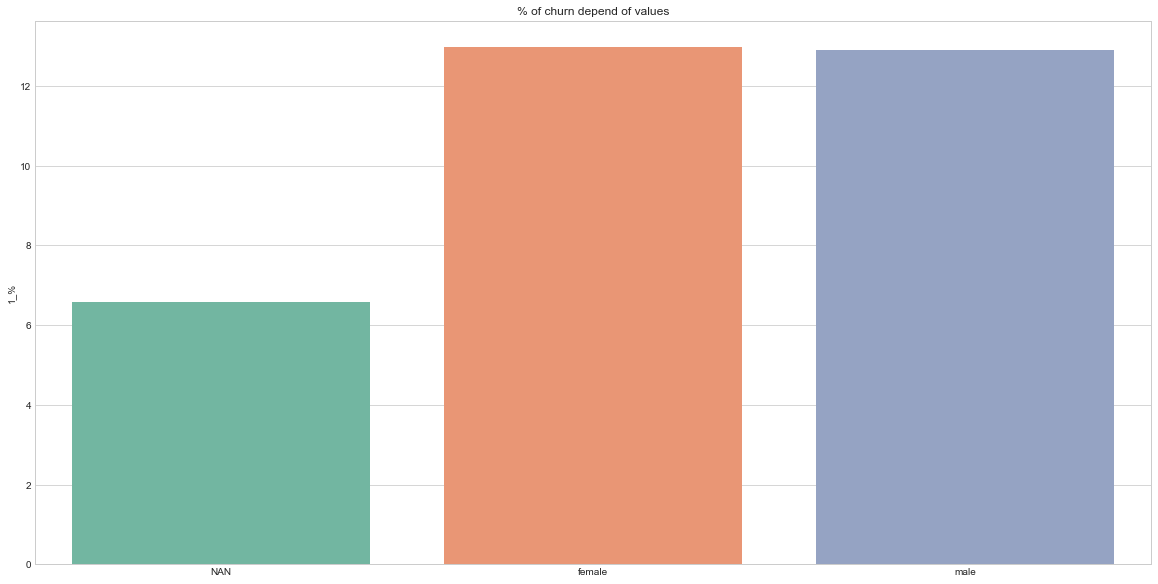

In [18]:
gender_crosstab=pd.crosstab(train_members['gender'],train_members['is_churn'])
gender_crosstab["0_%"] =  round(gender_crosstab[0]/(gender_crosstab[1]+gender_crosstab[0])*100, 2)
gender_crosstab["1_%"] =  round(gender_crosstab[1]/(gender_crosstab[1]+gender_crosstab[0])*100, 2)
gender_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = gender_crosstab.index.values, y = "1_%", data=gender_crosstab, palette="Set2").set_title("% of churn depend of values")

Distribution is almost equal for man and woman + we have missing values. In more deep analysis can be consider to try to predict gender of user. In this analysis we will rather treat this variable as not very informative and rather not use in model.

##### 2.2.4 Members ['registered_via']

Text(0,0.5,'Count')

Text(0.5,0,'registered_via')

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

Text(0.5,1,'Frequency of registered_via in train_members Data Set')

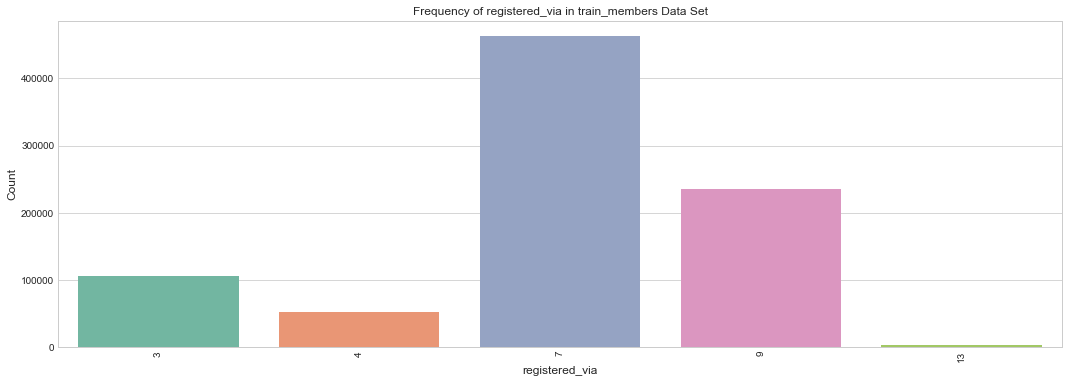

In [19]:
plt.figure(figsize=(18,6))
sns.countplot(x="registered_via", data=train_members, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('registered_via', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of registered_via in train_members Data Set", fontsize=12)
plt.show()

is_churn,0,1,0_%,1_%
registered_via,,,,
4,40559,12185,76.90,23.10
3,88121,18338,82.77,17.23
9,205796,29893,87.32,12.68
13,3056,335,90.12,9.88
7,441987,20697,95.53,4.47


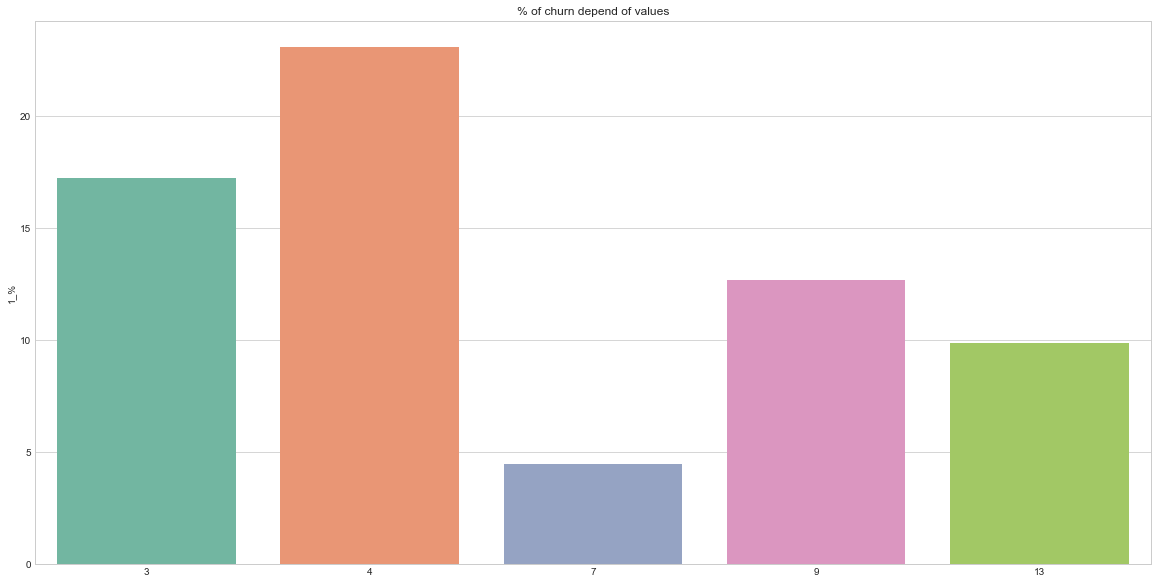

In [20]:
registered_via_crosstab=pd.crosstab(train_members['registered_via'],train_members['is_churn'])
registered_via_crosstab["0_%"] =  round(registered_via_crosstab[0]/(registered_via_crosstab[1]+registered_via_crosstab[0])*100, 2)
registered_via_crosstab["1_%"] =  round(registered_via_crosstab[1]/(registered_via_crosstab[1]+registered_via_crosstab[0])*100, 2)
registered_via_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = registered_via_crosstab.index.values, y = "1_%", data=registered_via_crosstab, palette="Set2").set_title("% of churn depend of values")

Majority users in given dataset register using method 7, which have as well lowest churn rate. We can consider building new feature with 3 clusters: 7; 9 and 13, 3 and 4.

##### 2.2.5 Members ['registration_init_time'] 

**Creation of 2 new feature containing information about month and weekday**

In [21]:
#train_members['registration_init_time_weekday_cat'] = pd.DatetimeIndex(train_members['registration_init_time']).weekday_name
train_members['registration_init_time_weekday'] = pd.DatetimeIndex(train_members['registration_init_time']).weekday
train_members['registration_init_time_month'] = pd.DatetimeIndex(train_members['registration_init_time']).month

In [22]:
train_members.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,registration_init_time_weekday,registration_init_time_month
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5,28,male,3,2013-12-23,0,12
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13,20,male,3,2013-12-23,0,12
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13,18,male,3,2013-12-27,4,12
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1,0,NAN,7,2014-01-09,3,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13,35,female,7,2014-01-25,5,1


Text(0,0.5,'Count')

Text(0.5,0,'registration_init_time_month')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

Text(0.5,1,'Frequency of registration_init_time_month in train_members Data Set')

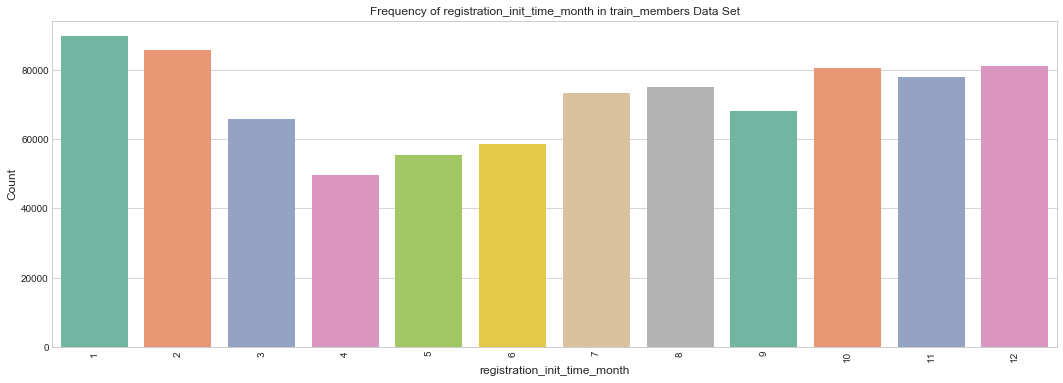

In [23]:
plt.figure(figsize=(18,6))
sns.countplot(x="registration_init_time_month", data=train_members, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('registration_init_time_month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of registration_init_time_month in train_members Data Set", fontsize=12)
plt.show()

is_churn,0,1,0_%,1_%
registration_init_time_month,,,,
3,58027,7911,88.00,12.00
2,76593,9035,89.45,10.55
1,80691,8949,90.02,9.98
9,61383,6602,90.29,9.71
4,45004,4728,90.49,9.51
6,53218,5364,90.84,9.16
5,50419,5025,90.94,9.06
12,73885,7345,90.96,9.04
10,73268,7260,90.98,9.02


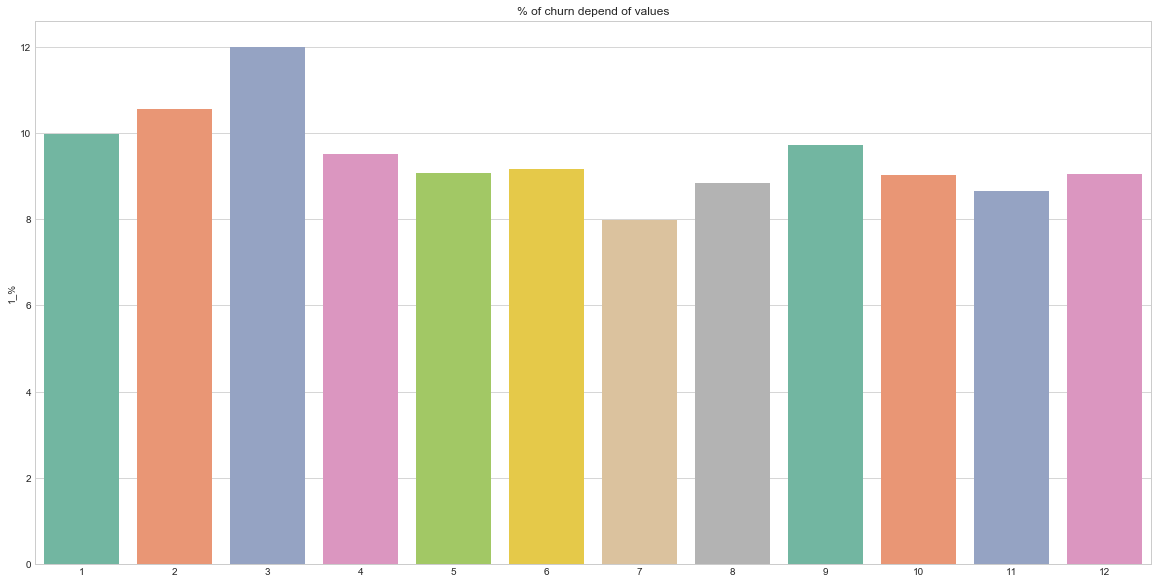

In [24]:
month_crosstab=pd.crosstab(train_members['registration_init_time_month'],train_members['is_churn'])
month_crosstab["0_%"] =  round(month_crosstab[0]/(month_crosstab[1]+month_crosstab[0])*100, 2)
month_crosstab["1_%"] =  round(month_crosstab[1]/(month_crosstab[1]+month_crosstab[0])*100, 2)
month_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = month_crosstab.index.values, y = "1_%", data=month_crosstab, palette="Set2").set_title("% of churn depend of values")

More users tend to churn at the first quarter of the year. Seasons split can be consider but there is no visible tendency besides already desribed one.

Text(0,0.5,'Count')

Text(0.5,0,'registration_init_time_weekday')

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

Text(0.5,1,'Frequency of registration_init_time_weekday in train_members Data Set')

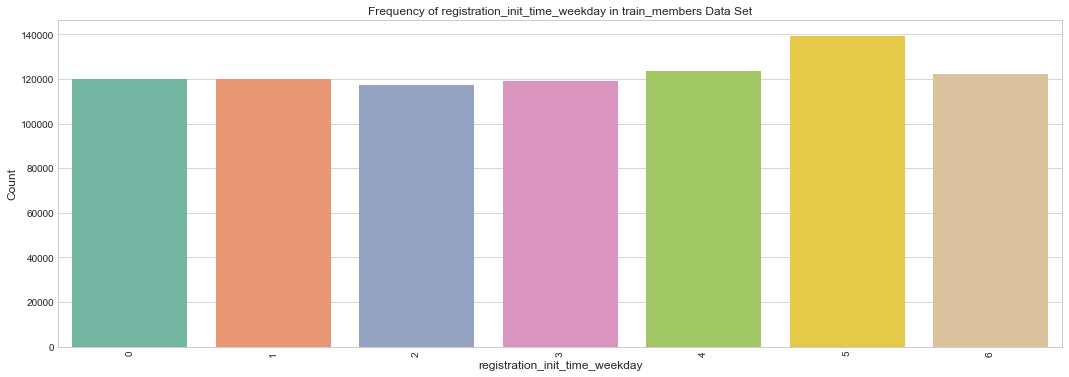

In [25]:
plt.figure(figsize=(18,6))
sns.countplot(x="registration_init_time_weekday", data=train_members, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('registration_init_time_weekday', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of registration_init_time_weekday in train_members Data Set", fontsize=12)
plt.show()

is_churn,0,1,0_%,1_%
registration_init_time_weekday,,,,
6,109904,12283,89.95,10.05
4,111931,11707,90.53,9.47
2,106259,11057,90.58,9.42
3,107685,11196,90.58,9.42
0,108717,11176,90.68,9.32
5,126299,12969,90.69,9.31
1,108724,11060,90.77,9.23


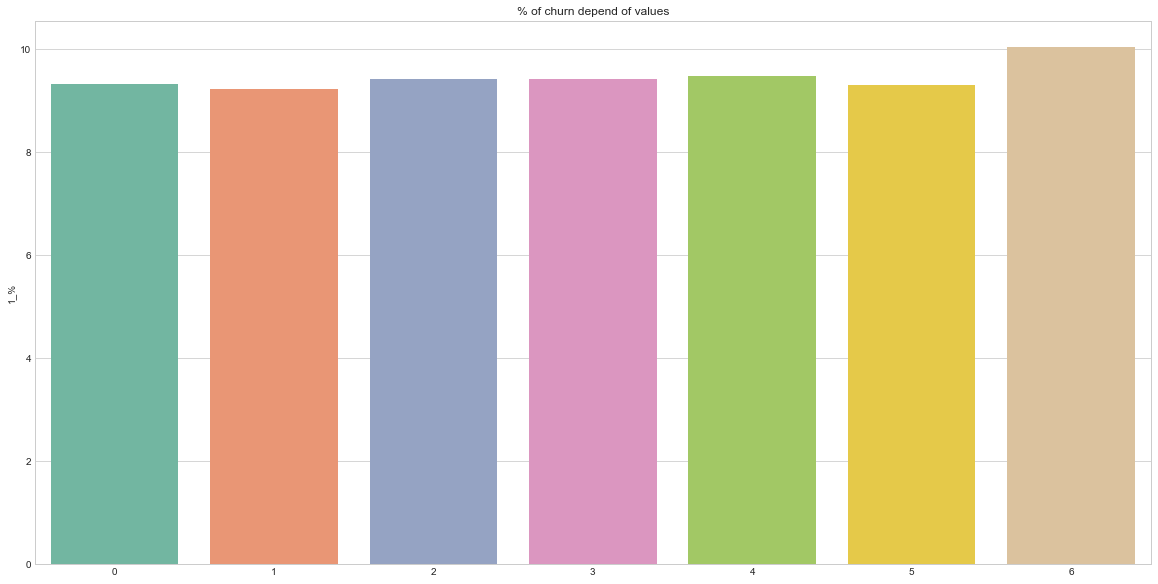

In [26]:
week_crosstab=pd.crosstab(train_members['registration_init_time_weekday'],train_members['is_churn'])
week_crosstab["0_%"] =  round(week_crosstab[0]/(week_crosstab[1]+week_crosstab[0])*100, 2)
week_crosstab["1_%"] =  round(week_crosstab[1]/(week_crosstab[1]+week_crosstab[0])*100, 2)
week_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = week_crosstab.index.values, y = "1_%", data=week_crosstab, palette="Set2").set_title("% of churn depend of values")

Distribution of churn per weekday is almost flat. This feature is not consider as very informative.

====================================================================================================
### 2.3 Transaction dataset

In [27]:
train_trans = pd.merge(left = df_train,right = df_transaction,how = 'inner',on=['msno'])
train_trans.head()
train_trans.info()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,36,30,180,180,0,20170311,20170411,0
1,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,17,60,0,0,0,20170311,20170314,0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,15,90,300,300,0,20170314,20170615,0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,41,30,149,149,1,20150908,20170608,0
4,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,41,30,149,149,1,20150908,20170708,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132036 entries, 0 to 1132035
Data columns (total 10 columns):
msno                      1132036 non-null object
is_churn                  1132036 non-null int64
payment_method_id         1132036 non-null int64
payment_plan_days         1132036 non-null int64
plan_list_price           1132036 non-null int64
actual_amount_paid        1132036 non-null int64
is_auto_renew             1132036 non-null int64
transaction_date          1132036 non-null int64
membership_expire_date    1132036 non-null int64
is_cancel                 1132036 non-null int64
dtypes: int64(9), object(1)
memory usage: 95.0+ MB


**Changing the format of the dates**

In [28]:
train_trans['transaction_date'] = train_trans.transaction_date.apply(
    lambda x: datetime.strptime(str(int(x)), "%Y%m%d").date() if pd.notnull(x) else "NAN" )
train_trans['membership_expire_date'] = train_trans.membership_expire_date.apply(
    lambda x: datetime.strptime(str(int(x)), "%Y%m%d").date() if pd.notnull(x) else "NAN")

In [29]:
train_trans.msno.unique().shape, train_trans.msno.shape

((933578,), (1132036,))

##### 2.3.1 Transactions['payment_method_id'] 

Text(0,0.5,'Count')

Text(0.5,0,'payment_method_id')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 33 Text xticklabel objects>)

Text(0.5,1,'Frequency of payment_method_id in train_members Data Set')

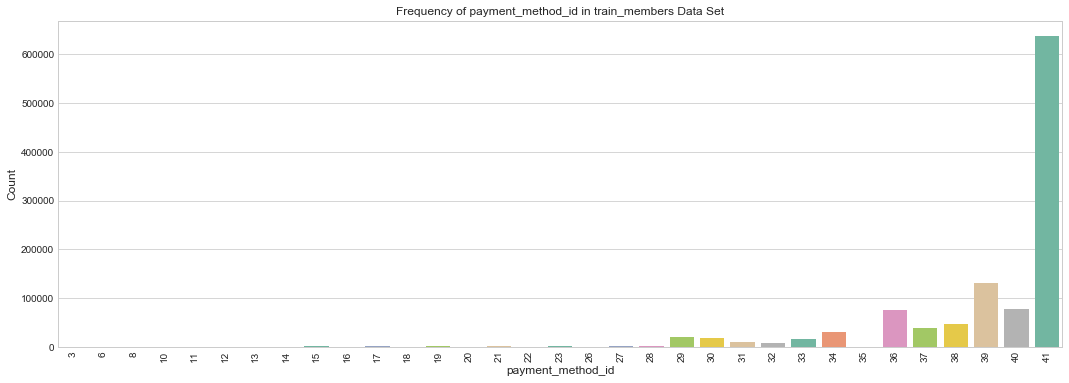

41    636230
39    131672
40     77817
36     76543
38     47420
37     38224
34     30088
29     19501
30     18017
33     15961
31     11034
32      8609
15      3001
23      2612
17      2283
19      2116
27      1929
21      1846
28      1792
16       918
20       859
35       807
18       672
14       666
22       488
13       307
12       267
26       214
11        79
10        40
8         10
3          9
6          5
Name: payment_method_id, dtype: int64

In [30]:
plt.figure(figsize=(18,6))
sns.countplot(x="payment_method_id", data=train_trans, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('payment_method_id', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of payment_method_id in train_members Data Set", fontsize=12)
plt.show()

train_trans.payment_method_id.value_counts()

In [31]:
636230/1132036

0.5620227625269868

is_churn,0,1,0_%,1_%
payment_method_id,,,,
3,0,9,0.00,100.00
6,0,5,0.00,100.00
13,1,306,0.33,99.67
22,2,486,0.41,99.59
20,5,854,0.58,99.42
32,309,8300,3.59,96.41
12,13,254,4.87,95.13
17,224,2059,9.81,90.19
8,1,9,10.00,90.00


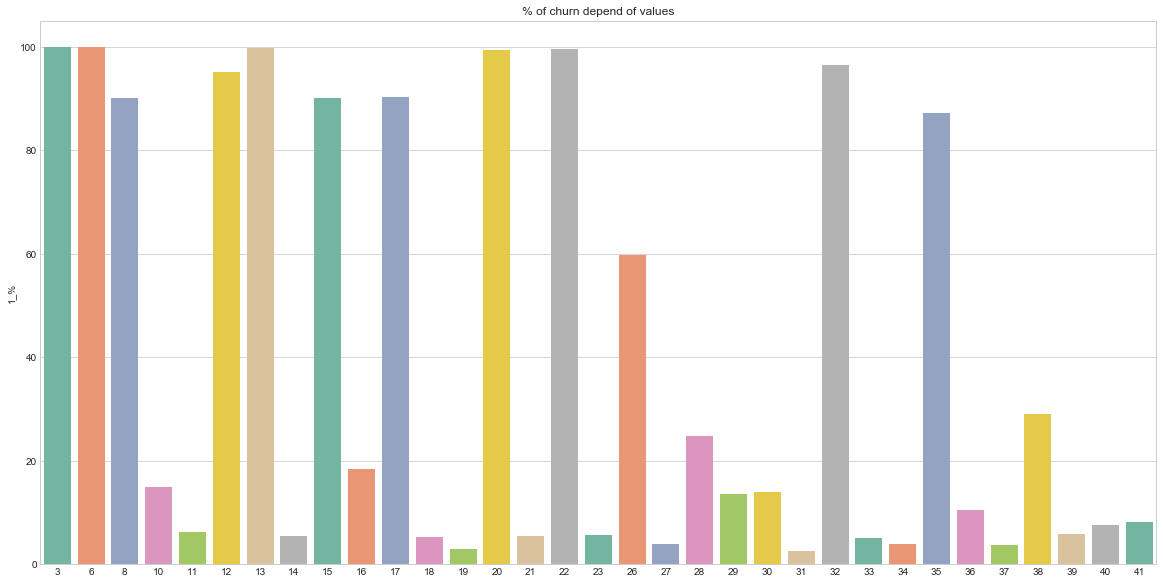

In [32]:
pay_met_id_crosstab=pd.crosstab(train_trans['payment_method_id'],train_trans['is_churn'])
pay_met_id_crosstab["0_%"] =  round(pay_met_id_crosstab[0]/(pay_met_id_crosstab[1]+pay_met_id_crosstab[0])*100, 2)
pay_met_id_crosstab["1_%"] =  round(pay_met_id_crosstab[1]/(pay_met_id_crosstab[1]+pay_met_id_crosstab[0])*100, 2)
pay_met_id_crosstab = pay_met_id_crosstab.sort_values('1_%', ascending = False)
pay_met_id_crosstab

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = pay_met_id_crosstab.index.values, y = "1_%", data=pay_met_id_crosstab, palette="Set2").set_title("% of churn depend of values")

56% of users used payment method 41. There are visible clusterings, as I suspect there is some co-dependecy, let's check what other links we can find in methoda with similar churn rate.

In [33]:
#train_trans.loc[train_trans['payment_method_id'] == 13]
#train_trans.loc[train_trans['payment_method_id'] == 20]
#train_trans.loc[train_trans['payment_method_id'] == 12]

So as we can clearly see there all have *'is_auto_renew'* = 0. Let's now check payment methods with low churn rate.

In [34]:
#train_trans.loc[train_trans['payment_method_id'] == 31]
#train_trans.loc[train_trans['payment_method_id'] == 19]
#train_trans.loc[train_trans['payment_method_id'] == 37]

Majority of *'is_auto_renew'* are equal 1. Let's explore further this dependencie to create new feature based on that.

In [35]:
pay_met_auto_crosstab=pd.crosstab(train_trans['payment_method_id'],train_trans['is_auto_renew'])
pay_met_auto_crosstab["is_auto_0"] =  round(pay_met_auto_crosstab[0]/(pay_met_auto_crosstab[1]+pay_met_auto_crosstab[0])*100, 2)
pay_met_auto_crosstab["is_auto_1"] =  round(pay_met_auto_crosstab[1]/(pay_met_auto_crosstab[1]+pay_met_auto_crosstab[0])*100, 2)
pay_met_auto_crosstab.sort_values('is_auto_0', ascending = False)
pay_met_auto_crosstab.shape

is_auto_renew,0,1,is_auto_0,is_auto_1
payment_method_id,,,,
3,9,0,100.00,0.00
26,214,0,100.00,0.00
22,488,0,100.00,0.00
35,807,0,100.00,0.00
20,859,0,100.00,0.00
32,8609,0,100.00,0.00
17,2283,0,100.00,0.00
15,3001,0,100.00,0.00
38,47420,0,100.00,0.00


(33, 4)

In [36]:
pay_met_temp = pd.merge(pay_met_id_crosstab, pay_met_auto_crosstab, left_index=True, right_index=True)
pay_met_temp.sort_values('is_auto_0', ascending = False)

pay_met_temp.shape

,0_x,1_x,0_%,1_%,0_y,1_y,is_auto_0,is_auto_1
payment_method_id,,,,,,,,
3,0,9,0.00,100.00,9,0,100.00,0.00
17,224,2059,9.81,90.19,2283,0,100.00,0.00
28,1348,444,75.22,24.78,1792,0,100.00,0.00
38,33632,13788,70.92,29.08,47420,0,100.00,0.00
26,86,128,40.19,59.81,214,0,100.00,0.00
35,104,703,12.89,87.11,807,0,100.00,0.00
15,300,2701,10.00,90.00,3001,0,100.00,0.00
8,1,9,10.00,90.00,10,0,100.00,0.00
12,13,254,4.87,95.13,267,0,100.00,0.00


(33, 8)

So we confirmed dependency, on FE we will create then new variable with 2 categories:
1. payment method with high churn rate and no auto renew
2. other data

##### 2.3.2 Transactions['payment_plan_days'] 

Text(0,0.5,'Count')

Text(0.5,0,'payment_plan_days')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

Text(0.5,1,'Frequency of payment_plan_days in train_members Data Set')

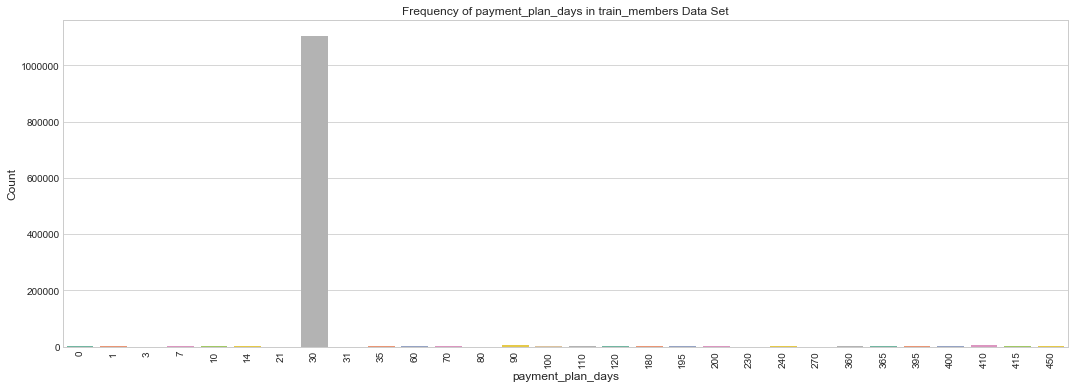

In [37]:
plt.figure(figsize=(18,6))
sns.countplot(x="payment_plan_days", data=train_trans, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('payment_plan_days', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of payment_plan_days in train_members Data Set", fontsize=12)
plt.show()

is_churn,0,1,0_%,1_%
payment_plan_days,,,,
110,0,12,0.00,100.00
31,0,3,0.00,100.00
400,0,153,0.00,100.00
395,0,293,0.00,100.00
270,0,9,0.00,100.00
230,0,2,0.00,100.00
80,0,10,0.00,100.00
35,0,22,0.00,100.00
450,0,78,0.00,100.00


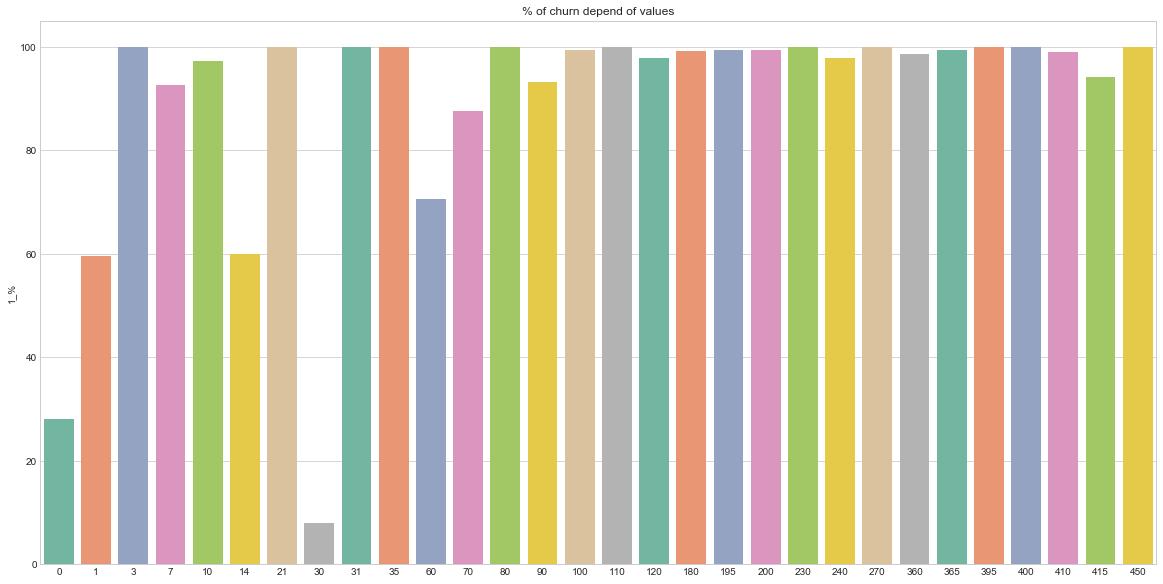

In [38]:
pay_plan_crosstab=pd.crosstab(train_trans['payment_plan_days'],train_trans['is_churn'])
pay_plan_crosstab["0_%"] =  round(pay_plan_crosstab[0]/(pay_plan_crosstab[1]+pay_plan_crosstab[0])*100, 2)
pay_plan_crosstab["1_%"] =  round(pay_plan_crosstab[1]/(pay_plan_crosstab[1]+pay_plan_crosstab[0])*100, 2)
pay_plan_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = pay_plan_crosstab.index.values, y = "1_%", data=pay_plan_crosstab, palette="Set2").set_title("% of churn depend of values")

As we can see most of the users chosen 30 days plan which make sende, as monthly subscription is common for those users churn rate is the lowest.
In FE I would create new feature based on this information with 5 clusters:
1. 30 days plan
2. plan with churn rate = 100%
3. plan with churn rate in range <87%, 100%)
4. plan with churn rate in range <70%, 50%>
5. plan with churn rate x > 50%

##### 2.3.3 Transactions['plan_list_price'] 

Text(0,0.5,'Count')

Text(0.5,0,'plan_list_price')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42]),
 <a list of 43 Text xticklabel objects>)

Text(0.5,1,'Frequency of plan_list_price in train_members Data Set')

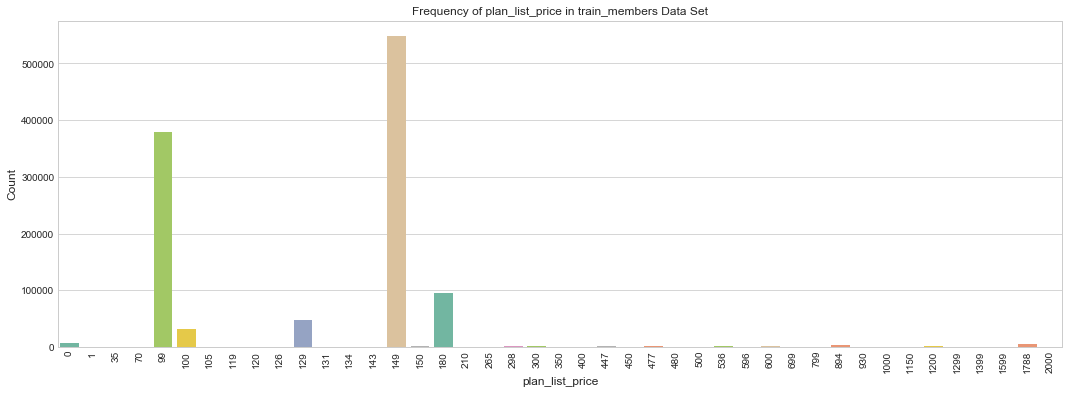

In [39]:
plt.figure(figsize=(18,6))
sns.countplot(x="plan_list_price", data=train_trans, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('plan_list_price', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of plan_list_price in train_members Data Set", fontsize=12)
plt.show()

is_churn,0,1,0_%,1_%
plan_list_price,,,,
2000,0,6,0.00,100.00
126,0,46,0.00,100.00
400,0,10,0.00,100.00
1,0,2,0.00,100.00
210,0,65,0.00,100.00
596,0,8,0.00,100.00
699,0,2,0.00,100.00
1000,0,38,0.00,100.00
799,0,95,0.00,100.00


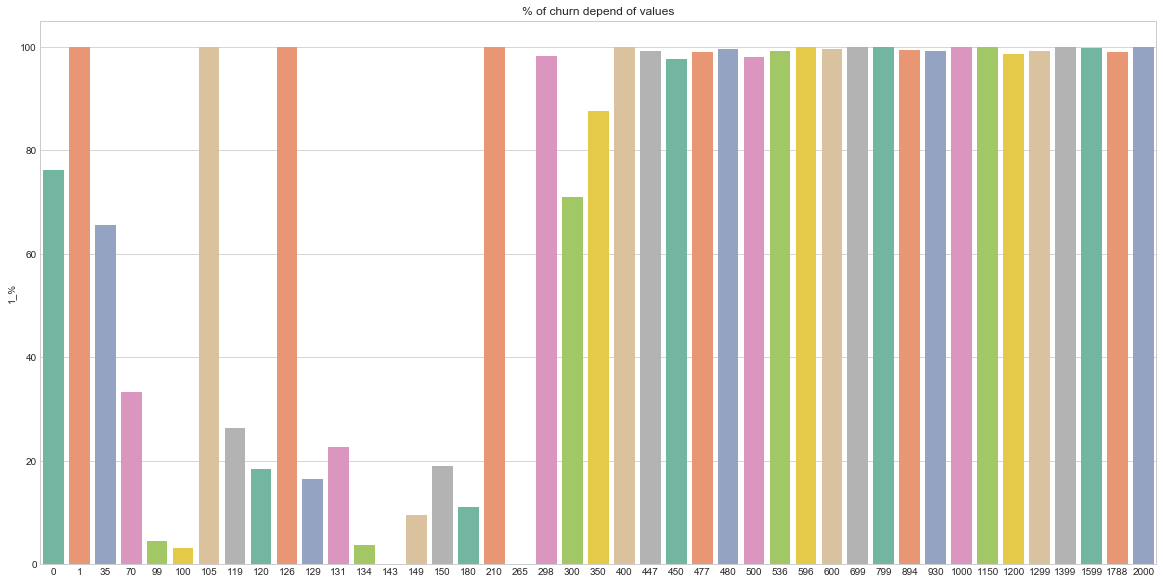

In [40]:
plan_list_price_crosstab=pd.crosstab(train_trans['plan_list_price'],train_trans['is_churn'])
plan_list_price_crosstab["0_%"] =  round(plan_list_price_crosstab[0]/(plan_list_price_crosstab[1]+plan_list_price_crosstab[0])*100, 2)
plan_list_price_crosstab["1_%"] =  round(plan_list_price_crosstab[1]/(plan_list_price_crosstab[1]+plan_list_price_crosstab[0])*100, 2)
plan_list_price_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = plan_list_price_crosstab.index.values, y = "1_%", data=plan_list_price_crosstab, palette="Set2").set_title("% of churn depend of values")

Let's check correlation bwith *payment_plan_days* as by common understanding those fetures should be highly dependent

In [41]:
train_trans['payment_plan_days'].corr(train_trans['plan_list_price'])

0.9423019231811397

High correlation between those 2 features is giving me information that it doesn't make sense to use both of them in model, hence I will use only *'payment_plan_days'* with cluster split.

Nevertheless inspired by https://www.kaggle.com/jeru666/did-you-think-of-these-features I will use *'plan_list_price'* to create *'discount'* feature.

In [42]:
train_trans['discount'] = train_trans['plan_list_price'] - train_trans['actual_amount_paid']
train_trans['discount'].unique()

array([   0,  149,  180, -149,   30, -119, -129,  120,   20,   50, -100,
         -1,   99,  129,    1, 1599], dtype=int64)

is_churn,0,1,0_%,1_%
discount,,,,
-1,0,46,0.00,100.00
120,0,10,0.00,100.00
149,221,763,22.46,77.54
129,2,2,50.00,50.00
180,1955,1169,62.58,37.42
-149,1054,434,70.83,29.17
-119,205,80,71.93,28.07
30,2220,865,71.96,28.04
-129,104,22,82.54,17.46


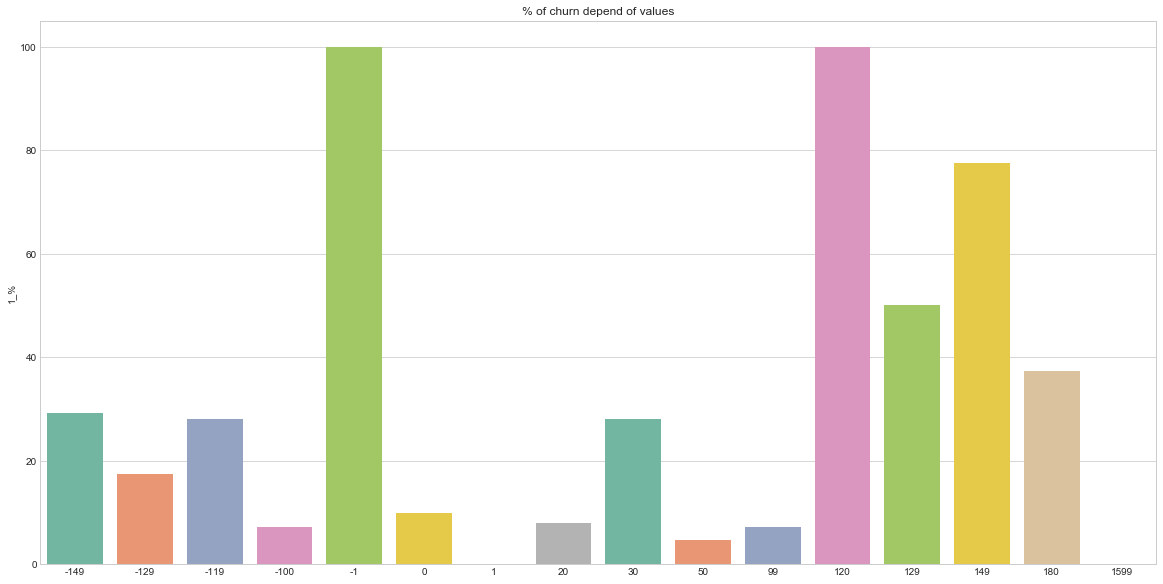

In [43]:
discount_crosstab=pd.crosstab(train_trans['discount'],train_trans['is_churn'])
discount_crosstab["0_%"] =  round(discount_crosstab[0]/(discount_crosstab[1]+discount_crosstab[0])*100, 2)
discount_crosstab["1_%"] =  round(discount_crosstab[1]/(discount_crosstab[1]+discount_crosstab[0])*100, 2)
discount_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = discount_crosstab.index.values, y = "1_%", data=discount_crosstab, palette="Set2").set_title("% of churn depend of values")

Majority of the people didn't got any discount. As distribution of churn rate didn't show strong patterns let's create binary variable *'is discount'*.

In [44]:
train_trans['is_discount'] = train_trans.discount.apply(lambda x: 1 if x>0 else 0)
train_trans['is_discount'].unique()

array([0, 1], dtype=int64)

##### 2.3.4 Transactions['actual_amount_paid'] 

In [45]:
train_trans['payment_plan_days'].corr(train_trans['plan_list_price'])
train_trans['actual_amount_paid'].corr(train_trans['plan_list_price'])

0.9423019231811397

0.9957775305801594

As suspected this feature is highly correlated with already explored *'plan_list_price'* hence will not explore further.

##### 2.3.5 Transactions['is_auto_renew'] 

Text(0,0.5,'Count')

Text(0.5,0,'is_auto_renew')

(array([0, 1]), <a list of 2 Text xticklabel objects>)

Text(0.5,1,'Frequency of payment_method_id in train_members Data Set')

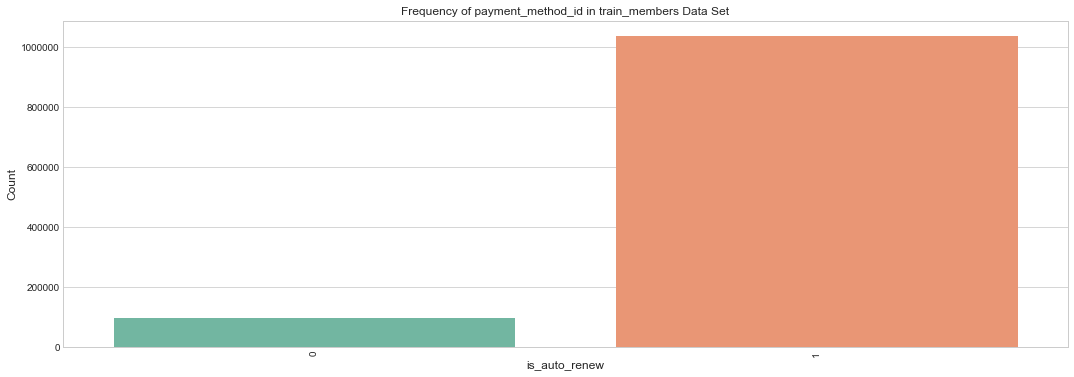

1    1037286
0      94750
Name: is_auto_renew, dtype: int64

In [46]:
plt.figure(figsize=(18,6))
sns.countplot(x="is_auto_renew", data=train_trans, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('is_auto_renew', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of payment_method_id in train_members Data Set", fontsize=12)
plt.show()

train_trans.is_auto_renew.value_counts()

In [47]:
auto_crosstab=pd.crosstab(train_trans['is_auto_renew'],train_trans['is_churn'])
auto_crosstab["0_%"] =  round(auto_crosstab[0]/(auto_crosstab[1]+auto_crosstab[0])*100, 2)
auto_crosstab["1_%"] =  round(auto_crosstab[1]/(auto_crosstab[1]+auto_crosstab[0])*100, 2)
auto_crosstab.sort_values('1_%', ascending = False)

is_churn,0,1,0_%,1_%
is_auto_renew,,,,
0,60576,34174,63.93,36.07
1,957887,79399,92.35,7.65


Not suprisingly we see that clients with automatic renewal less frequently unsubscribe.

##### 2.3.6 Transactions['transaction_date'] 

**Creation of new features with split for month and week**

In [48]:
train_trans['transaction_month'] = pd.DatetimeIndex(train_trans['transaction_date']).month
train_trans['transaction_weekday'] = pd.DatetimeIndex(train_trans['transaction_date']).weekday

Text(0,0.5,'Count')

Text(0.5,0,'transaction_month')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

Text(0.5,1,'Frequency of transaction_month in train_members Data Set')

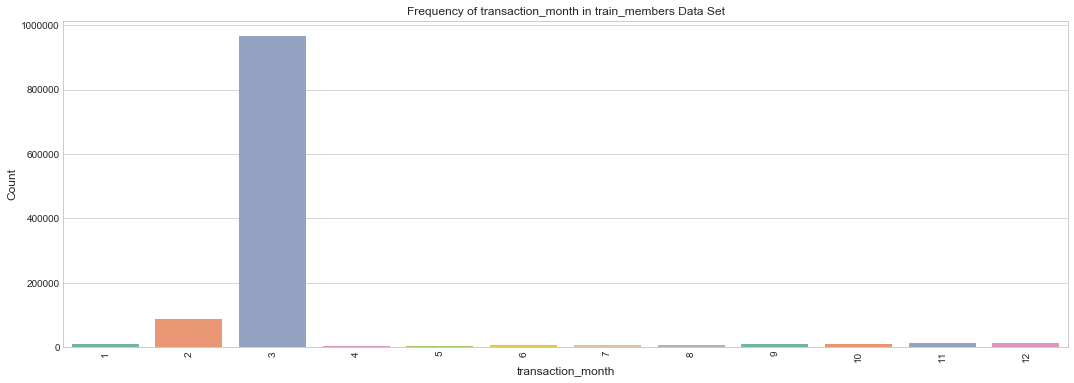

3     964972
2      87810
12     13328
11     12320
10     10022
1       8838
9       8014
8       7352
7       6844
6       5036
5       4186
4       3314
Name: transaction_month, dtype: int64

In [49]:
plt.figure(figsize=(18,6))
sns.countplot(x="transaction_month", data=train_trans, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('transaction_month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of transaction_month in train_members Data Set", fontsize=12)
plt.show()

train_trans['transaction_month'].value_counts()

In [50]:
964972/1132036 # march data %

0.8524216544350179

is_churn,0,1,0_%,1_%
transaction_month,,,,
1,1700,7138,19.24,80.76
12,7070,6258,53.05,46.95
7,4093,2751,59.80,40.20
10,6351,3671,63.37,36.63
11,7835,4485,63.60,36.40
9,5140,2874,64.14,35.86
8,4721,2631,64.21,35.79
6,3358,1678,66.68,33.32
5,2800,1386,66.89,33.11


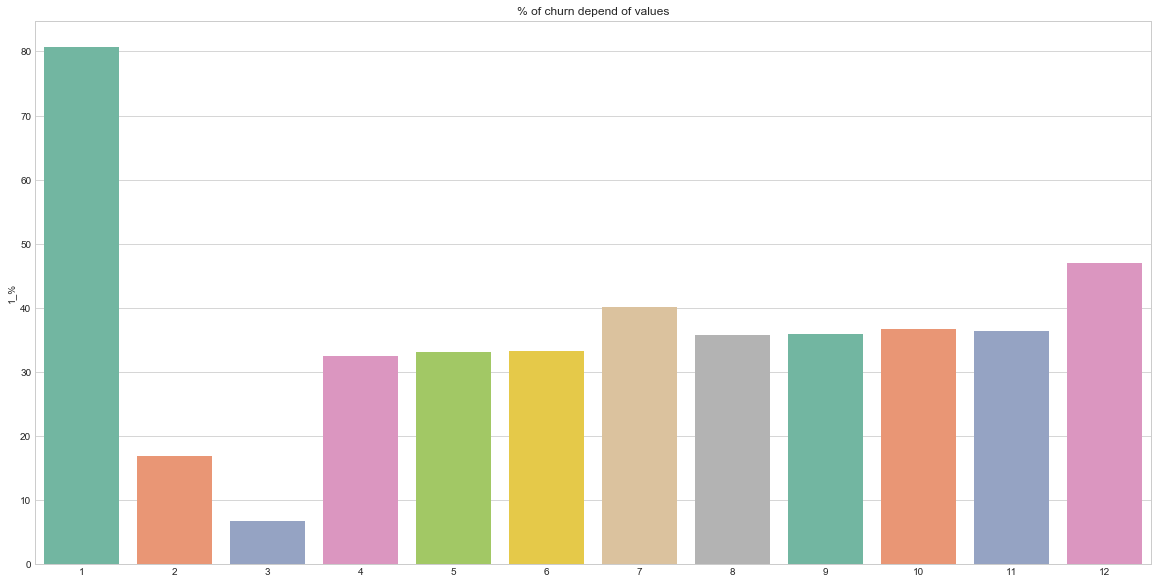

In [51]:
transaction_month_crosstab=pd.crosstab(train_trans['transaction_month'],train_trans['is_churn'])
transaction_month_crosstab["0_%"] =  round(transaction_month_crosstab[0]/(transaction_month_crosstab[1]+transaction_month_crosstab[0])*100, 2)
transaction_month_crosstab["1_%"] =  round(transaction_month_crosstab[1]/(transaction_month_crosstab[1]+transaction_month_crosstab[0])*100, 2)
transaction_month_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = transaction_month_crosstab.index.values, y = "1_%", data=transaction_month_crosstab, palette="Set2").set_title("% of churn depend of values")

Users tend to churn more often on Jan and Dec, and less often on Feb and March (let's keep in mind that 85% of data are for March). I will create new feature *'transaction_month_cat'* with split for mentioned 2 clusters + remaining months as 3rd cluster.

Text(0,0.5,'Count')

Text(0.5,0,'transaction_weekday')

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

Text(0.5,1,'Frequency of transaction_weekday in train_members Data Set')

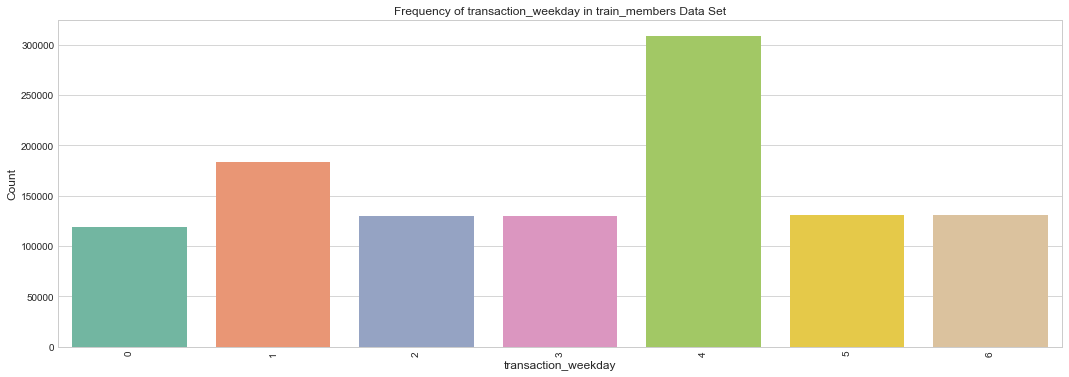

In [52]:
plt.figure(figsize=(18,6))
sns.countplot(x="transaction_weekday", data=train_trans, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('transaction_weekday', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of transaction_weekday in train_members Data Set", fontsize=12)
plt.show()

is_churn,0,1,0_%,1_%
transaction_weekday,,,,
2,111435,18066,86.05,13.95
0,104035,15199,87.25,12.75
3,114989,15192,88.33,11.67
5,115644,14912,88.58,11.42
1,163064,20246,88.96,11.04
6,117448,13183,89.91,10.09
4,291848,16775,94.56,5.44


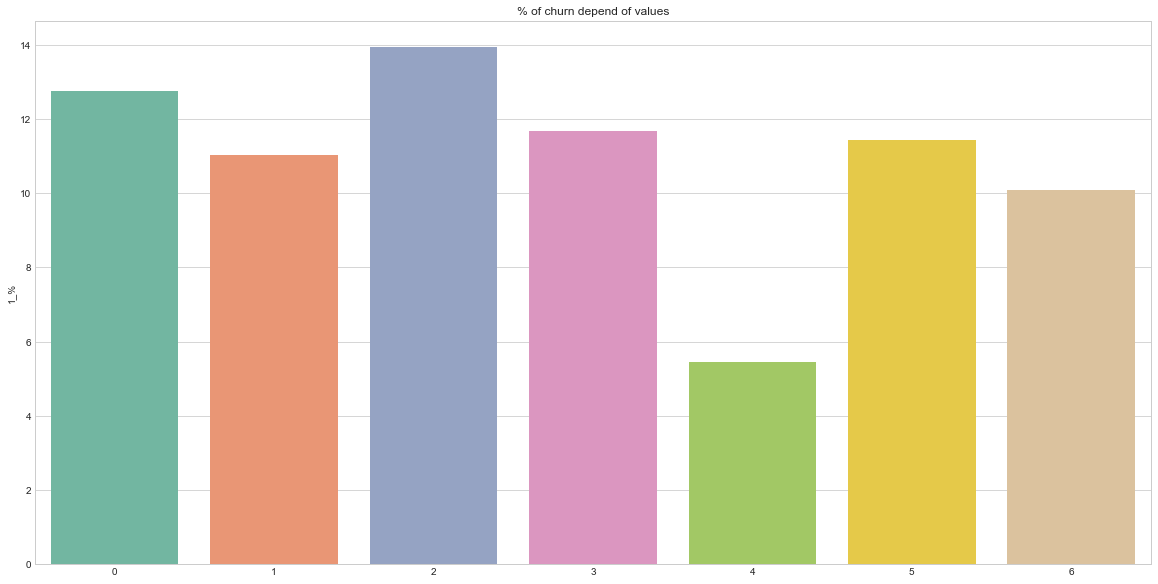

In [53]:
transaction_weekday_crosstab=pd.crosstab(train_trans['transaction_weekday'],train_trans['is_churn'])
transaction_weekday_crosstab["0_%"] =  round(transaction_weekday_crosstab[0]/(transaction_weekday_crosstab[1]+transaction_weekday_crosstab[0])*100, 2)
transaction_weekday_crosstab["1_%"] =  round(transaction_weekday_crosstab[1]/(transaction_weekday_crosstab[1]+transaction_weekday_crosstab[0])*100, 2)
transaction_weekday_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = transaction_weekday_crosstab.index.values, y = "1_%", data=transaction_weekday_crosstab, palette="Set2").set_title("% of churn depend of values")

Based on given data we can assume that users who made transactions on firday tend to less frequently unsubscribe. I will create binary feature for friday data.

##### 2.3.7 Transactions['membership_expire_date] 

**Creation of new features with split for month and week**

In [54]:
train_trans['membership_expire_month'] = pd.DatetimeIndex(train_trans['membership_expire_date']).month
train_trans['membership_expire_weekday'] = pd.DatetimeIndex(train_trans['membership_expire_date']).weekday

Text(0,0.5,'Count')

Text(0.5,0,'membership_expire_month')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

Text(0.5,1,'Frequency of membership_expire_month in train_members Data Set')

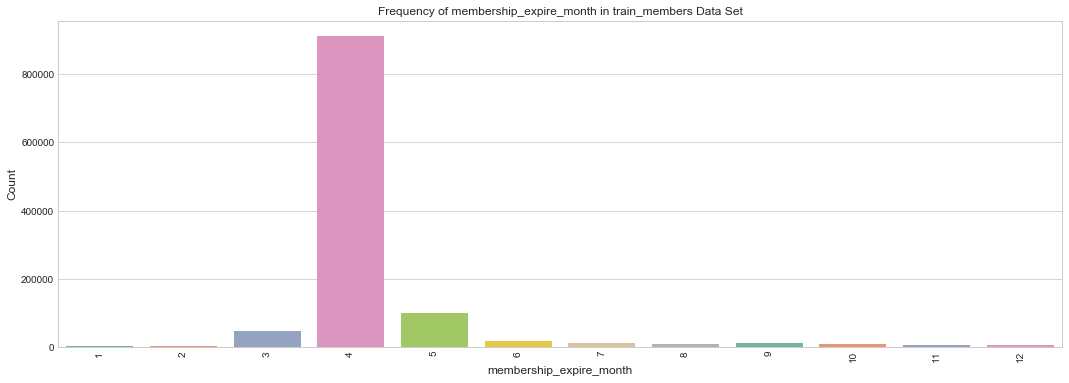

4     911224
5      99891
3      47600
6      17470
9      11145
7      10467
8       8217
10      7622
11      6184
12      4609
1       4180
2       3427
Name: membership_expire_month, dtype: int64

In [55]:
plt.figure(figsize=(18,6))
sns.countplot(x="membership_expire_month", data=train_trans, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('membership_expire_month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of membership_expire_month in train_members Data Set", fontsize=12)
plt.show()

train_trans['membership_expire_month'].value_counts()

In [56]:
911224/1132036 # percentage of April data

0.8049425989986184

is_churn,0,1,0_%,1_%
membership_expire_month,,,,
6,5801,11669,33.21,66.79
9,3959,7186,35.52,64.48
10,3714,3908,48.73,51.27
7,5104,5363,48.76,51.24
3,24495,23105,51.46,48.54
11,3312,2872,53.56,46.44
8,4514,3703,54.93,45.07
12,2932,1677,63.61,36.39
2,2210,1217,64.49,35.51


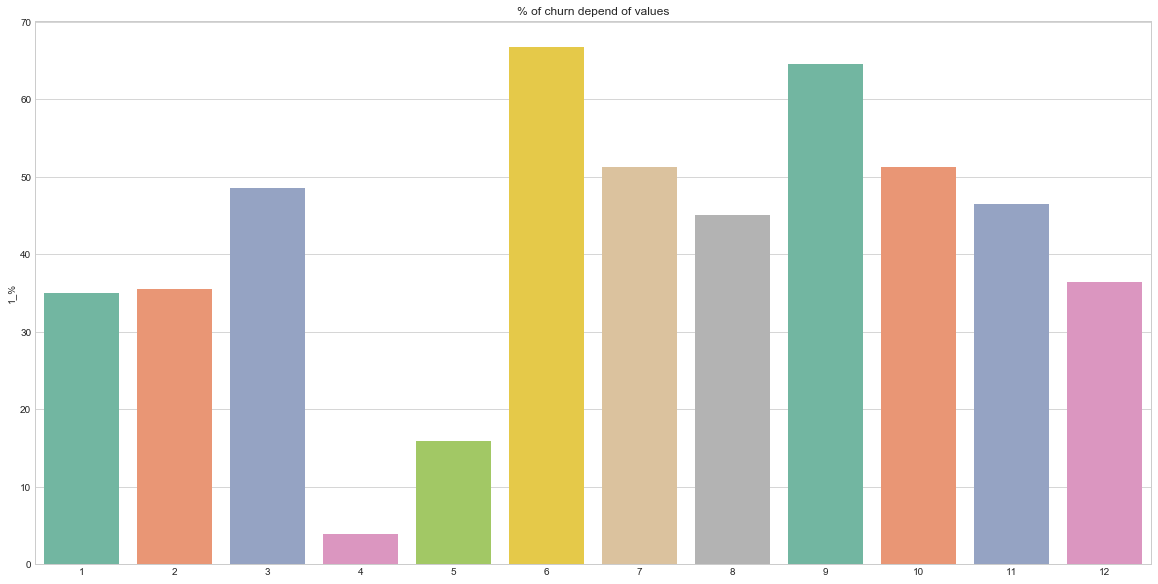

In [57]:
membership_expire_month_crosstab=pd.crosstab(train_trans['membership_expire_month'],train_trans['is_churn'])
membership_expire_month_crosstab["0_%"] =  round(membership_expire_month_crosstab[0]/(membership_expire_month_crosstab[1]+membership_expire_month_crosstab[0])*100, 2)
membership_expire_month_crosstab["1_%"] =  round(membership_expire_month_crosstab[1]/(membership_expire_month_crosstab[1]+membership_expire_month_crosstab[0])*100, 2)
membership_expire_month_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = membership_expire_month_crosstab.index.values, y = "1_%", data=membership_expire_month_crosstab, palette="Set2").set_title("% of churn depend of values")

I will explore further split months into clusters based on churn rate in FE phase. 

Text(0,0.5,'Count')

Text(0.5,0,'membership_expire_weekday')

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

Text(0.5,1,'Frequency of membership_expire_weekday in train_members Data Set')

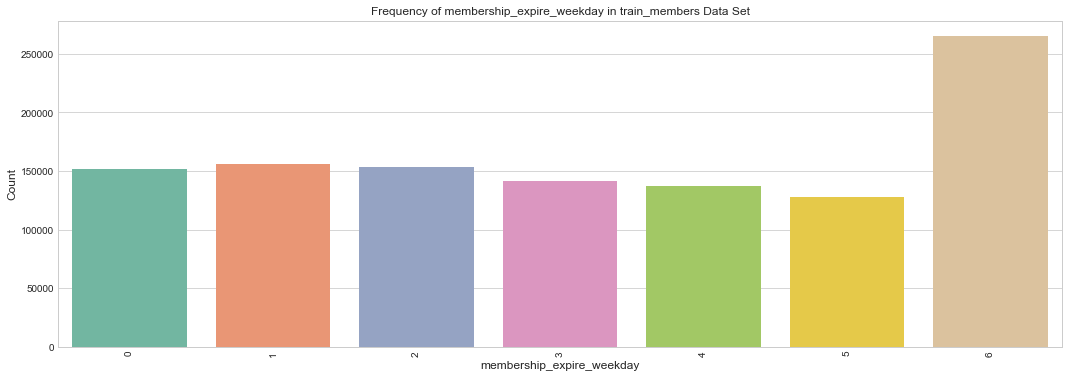

In [58]:
plt.figure(figsize=(18,6))
sns.countplot(x="membership_expire_weekday", data=train_trans, palette="Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('membership_expire_weekday', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of membership_expire_weekday in train_members Data Set", fontsize=12)
plt.show()

is_churn,0,1,0_%,1_%
membership_expire_weekday,,,,
4,119879,17127,87.50,12.50
5,111869,15781,87.64,12.36
2,135960,17815,88.41,11.59
3,125286,16045,88.65,11.35
0,135802,15638,89.67,10.33
1,140118,15495,90.04,9.96
6,249549,15672,94.09,5.91


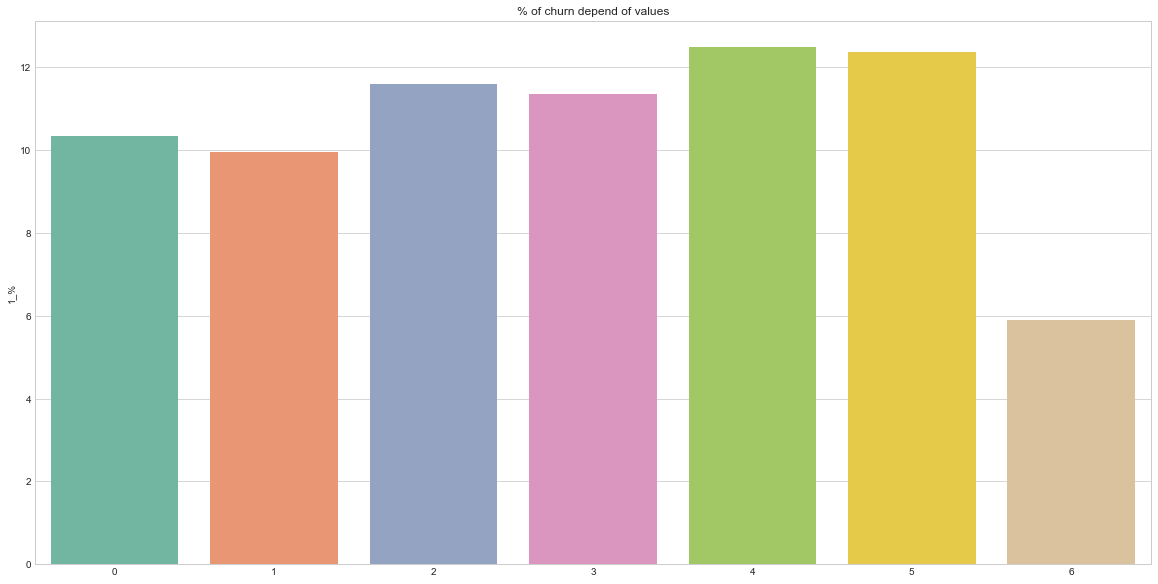

In [59]:
membership_expire_weekday_crosstab=pd.crosstab(train_trans['membership_expire_weekday'],train_trans['is_churn'])
membership_expire_weekday_crosstab["0_%"] =  round(membership_expire_weekday_crosstab[0]/(membership_expire_weekday_crosstab[1]+membership_expire_weekday_crosstab[0])*100, 2)
membership_expire_weekday_crosstab["1_%"] =  round(membership_expire_weekday_crosstab[1]/(membership_expire_weekday_crosstab[1]+membership_expire_weekday_crosstab[0])*100, 2)
membership_expire_weekday_crosstab.sort_values('1_%', ascending = False)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize']=(20,10)
ax = sns.barplot(x = membership_expire_weekday_crosstab.index.values, y = "1_%", data=membership_expire_weekday_crosstab, palette="Set2").set_title("% of churn depend of values")

I don't consider membership weekday feature as very insightful.

In [60]:
train_trans['membership_expire_date_fact'] = pd.factorize(train_trans['membership_expire_date'])[0]

##### 2.3.8 Transactions['is_cancel'] 

In [61]:
train_trans.is_cancel.value_counts()

0    1099153
1      32883
Name: is_cancel, dtype: int64

In [62]:
is_cancel_crosstab=pd.crosstab(train_trans['is_cancel'],train_trans['is_churn'])
is_cancel_crosstab["0_%"] =  round(is_cancel_crosstab[0]/(is_cancel_crosstab[1]+is_cancel_crosstab[0])*100, 2)
is_cancel_crosstab["1_%"] =  round(is_cancel_crosstab[1]/(is_cancel_crosstab[1]+is_cancel_crosstab[0])*100, 2)
is_cancel_crosstab.sort_values('1_%', ascending = False)

is_churn,0,1,0_%,1_%
is_cancel,,,,
1,13293,19590,40.43,59.57
0,1005170,93983,91.45,8.55


====================================================================================================
### 2.4 User_logs dataset

In [63]:
df_user_logs.head()
df_user_logs.describe()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=,20170331,8,4,0,1,21,18,6309.273
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=,20170330,2,2,1,0,9,11,2390.699
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=,20170331,52,3,5,3,84,110,23203.337
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=,20170331,176,4,2,2,19,191,7100.454
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=,20170331,2,1,0,1,112,93,28401.558


,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07,1.839636e+07
mean,2.017032e+07,6.191401e+00,1.508789e+00,9.413759e-01,1.079905e+00,3.028246e+01,2.903615e+01,7.904814e+03
std,8.916720e+00,1.342827e+01,3.908539e+00,1.924840e+00,3.518409e+00,4.203641e+01,3.219866e+01,1.013632e+04
min,2.017030e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e-03
25%,2.017031e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,8.000000e+00,1.959944e+03
50%,2.017032e+07,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.700000e+01,1.800000e+01,4.582990e+03
75%,2.017032e+07,7.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,3.700000e+01,3.800000e+01,9.848441e+03
max,2.017033e+07,5.639000e+03,9.120000e+02,5.080000e+02,1.561000e+03,4.110700e+04,4.925000e+03,9.194059e+06


As this dataset is huge to get useful information let's get mean() and sum() per user form it

In [64]:
df_user_logs.columns

Index(['msno', 'date', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100',
       'num_unq', 'total_secs'],
      dtype='object')

In [65]:
user_logs_cols = ['msno', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']
user_mean = df_user_logs[user_logs_cols].groupby(['msno']).mean().reset_index()
user_mean.columns = ['msno', 'num_25_mean', 'num_50_mean', 'num_75_mean', 'num_985_mean', 'num_100_mean', 'num_unq_mean', 'total_secs_mean']
user_mean.head()

,msno,num_25_mean,num_50_mean,num_75_mean,num_985_mean,num_100_mean,num_unq_mean,total_secs_mean
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,3.307692,0.423077,0.384615,0.192308,18.153846,20.384615,4534.900962
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,6.161290,2.903226,2.419355,4.645161,19.000000,28.548387,6210.577161
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,1.535714,0.428571,0.535714,0.428571,17.321429,16.714286,4121.830714
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,9.857143,7.761905,4.761905,3.047619,20.761905,39.428571,7137.931333
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,3.620690,0.827586,1.344828,1.206897,16.517241,7.931034,4014.939552


In [66]:
user_sum = df_user_logs[user_logs_cols].groupby(['msno']).sum().reset_index()
user_sum.columns = ['msno', 'num_25_sum', 'num_50_sum', 'num_75_sum', 'num_985_sum', 'num_100_sum', 'num_unq_sum', 'total_secs_sum']
user_sum.head()
user_sum.info()

,msno,num_25_sum,num_50_sum,num_75_sum,num_985_sum,num_100_sum,num_unq_sum,total_secs_sum
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,86,11,10,5,472,530,117907.425
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,191,90,75,144,589,885,192527.892
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,43,12,15,12,485,468,115411.260
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,207,163,100,64,436,828,149896.558
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,105,24,39,35,479,230,116433.247


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103894 entries, 0 to 1103893
Data columns (total 8 columns):
msno              1103894 non-null object
num_25_sum        1103894 non-null int64
num_50_sum        1103894 non-null int64
num_75_sum        1103894 non-null int64
num_985_sum       1103894 non-null int64
num_100_sum       1103894 non-null int64
num_unq_sum       1103894 non-null int64
total_secs_sum    1103894 non-null float64
dtypes: float64(1), int64(6), object(1)
memory usage: 67.4+ MB


In [67]:
train_user = pd.merge(left = df_train, right = user_mean, how = 'inner',on=['msno'])
train_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 754551 entries, 0 to 754550
Data columns (total 9 columns):
msno               754551 non-null object
is_churn           754551 non-null int64
num_25_mean        754551 non-null float64
num_50_mean        754551 non-null float64
num_75_mean        754551 non-null float64
num_985_mean       754551 non-null float64
num_100_mean       754551 non-null float64
num_unq_mean       754551 non-null float64
total_secs_mean    754551 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 57.6+ MB


In [68]:
train_user = pd.merge(left = train_user,right = user_sum, how = 'inner',on=['msno'])
train_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 754551 entries, 0 to 754550
Data columns (total 16 columns):
msno               754551 non-null object
is_churn           754551 non-null int64
num_25_mean        754551 non-null float64
num_50_mean        754551 non-null float64
num_75_mean        754551 non-null float64
num_985_mean       754551 non-null float64
num_100_mean       754551 non-null float64
num_unq_mean       754551 non-null float64
total_secs_mean    754551 non-null float64
num_25_sum         754551 non-null int64
num_50_sum         754551 non-null int64
num_75_sum         754551 non-null int64
num_985_sum        754551 non-null int64
num_100_sum        754551 non-null int64
num_unq_sum        754551 non-null int64
total_secs_sum     754551 non-null float64
dtypes: float64(8), int64(7), object(1)
memory usage: 97.9+ MB


In [69]:
#check
df_user_logs.loc[df_user_logs['msno'] == 'ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=']
user_sum.loc[user_sum['msno'] == 'ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=']
user_mean.loc[user_mean['msno'] == 'ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=']
train_user.loc[train_user['msno'] == 'ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=']

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
1335908,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170305,7,0,3,5,71,68,17599.893
1527474,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170301,138,19,7,1,21,158,8830.433
5079638,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170319,0,0,0,0,34,17,7883.313
7439185,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170316,15,0,0,1,38,17,9029.227
8818754,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170310,0,0,0,0,8,8,1870.110
10259157,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170321,0,0,0,0,31,17,7198.801
10292003,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170325,1,0,1,0,17,14,4106.712
10621805,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170329,8,1,1,0,5,14,1491.041
11615763,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170326,1,1,0,0,1,3,340.663
12320676,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,20170307,7,1,1,3,6,15,2269.019


,msno,num_25_sum,num_50_sum,num_75_sum,num_985_sum,num_100_sum,num_unq_sum,total_secs_sum
1012962,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,186,23,13,10,318,348,80598.557


,msno,num_25_mean,num_50_mean,num_75_mean,num_985_mean,num_100_mean,num_unq_mean,total_secs_mean
1012962,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,16.909091,2.090909,1.181818,0.909091,28.909091,31.636364,7327.141545


,msno,is_churn,num_25_mean,num_50_mean,num_75_mean,num_985_mean,num_100_mean,num_unq_mean,total_secs_mean,num_25_sum,num_50_sum,num_75_sum,num_985_sum,num_100_sum,num_unq_sum,total_secs_sum
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,16.909091,2.090909,1.181818,0.909091,28.909091,31.636364,7327.141545,186,23,13,10,318,348,80598.557


# 3. Feature Engineering

### 3.1 FE members

In [70]:
train_members.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 860967 entries, 0 to 860966
Data columns (total 9 columns):
msno                              860967 non-null object
is_churn                          860967 non-null int64
city                              860967 non-null int64
bd                                860967 non-null int64
gender                            860967 non-null object
registered_via                    860967 non-null int64
registration_init_time            860967 non-null object
registration_init_time_weekday    860967 non-null int64
registration_init_time_month      860967 non-null int64
dtypes: int64(6), object(3)
memory usage: 105.7+ MB


In [71]:
train_members['registration_init_time_fact'] = pd.factorize(train_members['registration_init_time'] )[0]

In [72]:
train_members['city_capital'] = train_members['city']
train_members['city_capital'] = train_members.city_capital.apply(lambda x: 1 if x==1  else 0)
train_members['city_capital'].value_counts()

1    442598
0    418369
Name: city_capital, dtype: int64

In [73]:
train_members['bd_teen'] = train_members['bd']
train_members['bd_teen'] = train_members.bd_teen.apply(lambda x: 0 if x<11 or x>=20  else 1)
train_members.bd_teen.value_counts()

0    833217
1     27750
Name: bd_teen, dtype: int64

In [74]:
train_members['seasons'] = train_members['registration_init_time_month']
train_members['seasons'] = train_members.seasons.apply(lambda x: 1 if x==3 or x==2 else x)
train_members['seasons'] = train_members.seasons.apply(lambda x: 2 if x in[4,5,6,8,9,10,11,12] else x)
train_members['seasons'] = train_members.seasons.apply(lambda x: 3 if x==7 else x)
train_members.seasons.value_counts()

2    546557
1    241206
3     73204
Name: seasons, dtype: int64

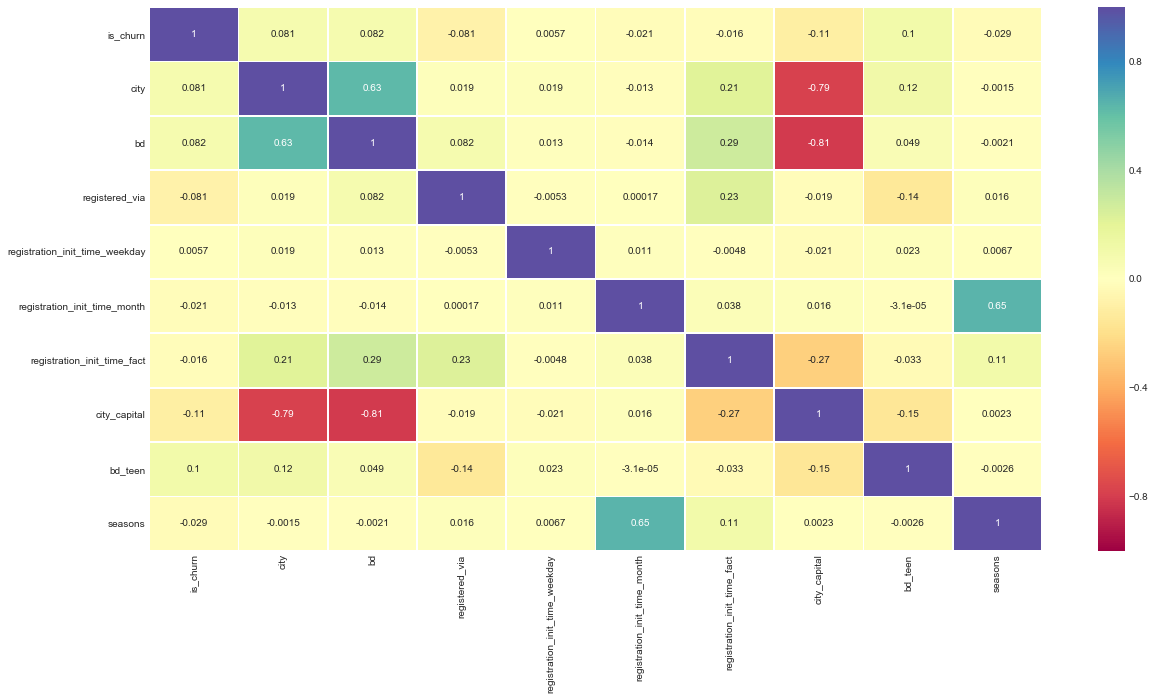

In [ ]:
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(train_members.corr(method='pearson'), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="Spectral");

**Observations**
<br><br>*target_variable x features corr*
1. There is no visible significant correlation with target variable
2. Highest correlation we can see with newly created features *city_capital* & *bd_teen* 

*feature x feature corr*
1. Ther is higher correlation between *registration_init_time* x *city_capital* and *city_capital* x *bd_teen* -> I will create feature for *capital_teens*

we can already drop on this stage not useful columns: registration_init_time_weekday and gender

<br>

In [ ]:
train_members.drop(['registration_init_time_weekday', 'gender'], axis=1)

In [ ]:
train_members['capital_teens'] = (train_members.city_capital == 1) & (train_members.bd_teen == 0)

In [ ]:
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(train_members.corr(method='pearson'), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="Spectral");

### 3.2 FE transactions

In [ ]:
train_trans.info()

In [ ]:
train_trans['pay_met_is_auto_cat'] = train_trans['payment_method_id']
train_trans['pay_met_is_auto_cat'] = train_trans.pay_met_is_auto_cat.apply(lambda x: 0 if x in [3,6,13,22,20,32,12,17,8,15,35,26,38,28
] else 1)
train_trans['pay_met_is_auto_cat'].value_counts()

In [ ]:
train_trans['transaction_month_cat'] = train_trans['transaction_month']
train_trans['transaction_month_cat'] = train_trans.transaction_month_cat.apply(lambda x: 20 if x in [1,12] else x)
train_trans['transaction_month_cat'] = train_trans.transaction_month_cat.apply(lambda x: 30 if x in [4,5,6,7,8,9,10,11] else x)
train_trans['transaction_month_cat'] = train_trans.transaction_month_cat.apply(lambda x: 40 if x in [2,3] else x)
train_trans['transaction_month_cat'].value_counts()

In [ ]:
train_trans['transaction_week_friday'] = train_trans['transaction_weekday']
train_trans['transaction_week_friday'] = train_trans.transaction_week_friday.apply(lambda x: 1 if x in [4] else 0)
train_trans['transaction_week_friday'].value_counts()

In [ ]:
#this correlate with is_churn 0.47 like one below but have higher correlation with is_cancel hence I choose lower one
train_trans['membership_expire_month_cat'] = train_trans['membership_expire_month']
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 60 if x in [6,9] else x)
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 40 if x in [10,7,3,11,8] else x)
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 30 if x in [12,2,1] else x)
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 20 if x in [5,4] else x)

In [ ]:
train_trans['membership_expire_month_cat'] = train_trans['membership_expire_month']
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 60 if x in [6,9] else x)
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 50 if x in [10,7] else x)
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 40 if x in [3,11,8] else x)
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 30 if x in [12,2,1] else x)
train_trans['membership_expire_month_cat'] = train_trans.membership_expire_month_cat.apply(lambda x: 20 if x in [5,4] else x)

In [ ]:
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(train_trans.corr(method='pearson'), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="Spectral");

**Observations**
<br><br>*target_variable x features corr*
1. Target variable correlate the most with created features *membership_expire_month_cat*, *payment_plan_cat*
2. Few feature with corr>20% suggest that transactions data can have highest importance in models, we will evaluate that
3. I was counting on higher correlation with discount features, let's explore further their importance while testing models

*feature x feature corr*
1. Highest features correlations were already mentioned and analyze in EDA
<br>

# 4. Merge and Model

In [ ]:
train_members.info()
train_trans.info()
train_user.info()

In [ ]:
data = pd.merge(left = train_members,right = train_trans, how = 'right',on=['msno'])
data.info()

In [ ]:
data = pd.merge(left = train_user,right = data, how = 'right',on=['msno'])
data.info()

In [ ]:
data.drop(['is_churn','is_churn_x'], axis = 1)

In [ ]:
data = data.fillna(-1)
data.info()

In [ ]:
data.bd_teen.value_counts(dropna = False)

In [ ]:
cat_feats = data.select_dtypes(include=[np.object]).columns

for cat_feat in cat_feats:
    data['{0}_facat'.format(cat_feat)] = pd.factorize(data[cat_feat] )[0]

In [ ]:
corr = data.corr(method='pearson')
type(corr)
corr.is_churn_y.sort_values()

In [ ]:
feats = list(data.columns)
rem = ['is_churn','is_churn_x','gender','is_churn_y','registration_init_time', 'transaction_date', 'membership_expire_date', 'msno']
for i in rem:
    feats.remove(i)
feats

In [ ]:
len(feats), data.shape

In [ ]:
X = data[feats]
y =  data['is_churn_y'] 

In [ ]:
def train_and_predict(model, X, y, test_size=0.33):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)
    
    model.fit(X_train, y_train)    
    y_pred = model.predict(X_test) 
    
    #print(classification_report(y_test, y_pred))
    return accuracy_score(y_test, y_pred)

In [ ]:
model = DecisionTreeClassifier()

In [ ]:
train_and_predict(model, X, y)

In [ ]:
def plot_learning_curve(model, X, y, title = 'Learning Curves', ylim=(.0,1.02), cv=3,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(roc_auc_score))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    
    return plt

In [ ]:
plt = plot_learning_curve(model, "Learning Curves: Decision Trees", X, y, cv=5, n_jobs=-1) 
plt.show()